In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import *

In [2]:
DATA_FOLDER = "../Data/"
actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID":parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_list,
        "countries": parse_list,
        "genres": parse_list
    },
)

In [3]:
actors = actors_load.copy()
movies = movies_load.copy()

In [4]:
actors_exp = explode_on_movies(actors)

In [5]:
movies.head()

,fbID,movieName,boxOffice,runtime,languages,countries,genresCmu,releaseMonth,releaseYear,imdbID,titleType,originalTitle,isAdult,endYear,genresImdb,averageRating,numVotes,combinedGenres,genres
0,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English Language],[United States of America],"['Mystery', 'Biographical film', 'Drama', 'Cri...",2.0,2000.0,tt0245916,tvMovie,Getting Away with Murder: The JonBenet Ramsey ...,0.0,\N,['Drama'],6.0,69.0,"{'Crime Drama', 'Biographical film', 'Drama', ...","{Mystery, Crime, Drama}"
1,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian Language],[Norway],"['Crime Fiction', 'Drama']",NaN,1988.0,tt0094806,movie,Brun bitter,0.0,\N,"['Crime', 'Drama']",5.6,40.0,"{'Crime Fiction', 'Drama', 'Crime'}","{Drama, Crime, Fiction}"
2,/m/0285_cd,White Of The Eye,NaN,110.0,[English Language],[United Kingdom],"['Thriller', 'Erotic thriller', 'Psychological...",NaN,1987.0,tt0094320,movie,White of the Eye,0.0,\N,"['Horror', 'Mystery', 'Thriller']",6.1,2885.0,"{'Horror', 'Erotic thriller', 'Mystery', 'Thri...","{Thriller, Mystery, Horror}"
3,/m/01mrr1,A Woman in Flames,NaN,106.0,[German Language],[Germany],['Drama'],NaN,1983.0,tt0083949,movie,Die flambierte Frau,0.0,\N,['Drama'],6.0,621.0,{'Drama'},{Drama}
4,/m/03cfc81,The Gangsters,NaN,35.0,"[Silent film, English Language]",[United States of America],"['Short Film', 'Silent film', 'Indie', 'Black-...",5.0,1913.0,tt0002894,short,The Gangsters,0.0,\N,"['Comedy', 'Short']",6.8,16.0,"{'Comedy', 'Short', 'Short Film', 'Indie', 'Si...","{Indie, Comedy, Short, Black-and-white, Silent}"


In [6]:
actors_movies = actors_exp.merge(movies[["fbID","genres","releaseMonth","releaseYear"]], how="left", on="fbID")

In [7]:
actors_movies_sort = actors_movies.sort_values(by=["fbActorID", "ageAtMovieRelease","releaseYear","releaseMonth"])

In [8]:
actors_min_movies = actors_movies_sort.query("numMovies >=30")

In [9]:
actors_min_movies = actors_min_movies[
    ~(actors_min_movies.ageAtMovieRelease.isna() & actors_min_movies.releaseYear.isna())
]
actors_min_movies = actors_min_movies[~actors_min_movies.genres.isna()]

In [10]:
actors_min_movies["genresLen"] = actors_min_movies.genres.apply(lambda x:len(x))

In [11]:
actors_min_movies["LastMovie"] = np.array([*(actors_min_movies.fbActorID[1:].values != actors_min_movies.fbActorID.values[:-1]),True]) 

In [12]:
actors_min_movies.genres.value_counts()

genres
{Drama}                                                                5348
{Comedy}                                                               3090
{Comedy, Romance, Drama}                                               2359
{Romance, Drama}                                                       2289
{Comedy, Drama}                                                        1998
                                                                       ... 
{Thriller, Drama, Adventure, Action, Fiction, World, Crime, Horror}       1
{Mystery, Western}                                                        1
{Mystery, Western, Action, Drama}                                         1
{Thriller, Black-and-white, Mystery, Fiction, World, Crime}               1
{Thriller, Family, Fantasy, Drama, Horror}                                1
Name: count, Length: 4508, dtype: int64

In [13]:
genreslist = actors_min_movies.genres.explode().unique()

In [14]:
actors_min_movies.genres.explode().value_counts()

genres
Drama              60140
Comedy             36693
Romance            25563
Action             25483
Adventure          19719
Thriller           19633
Crime              18675
Fiction            17847
World              11335
Family             11004
Black-and-white    10620
Musical            10109
Indie               8865
Mystery             7730
Fantasy             6043
Horror              5174
Short               4968
War                 4548
Western             4277
Science             4132
Animation           4123
Biography           3386
Silent              3230
History             2766
Japanese             961
Documentary          693
Name: count, dtype: int64

In [15]:
index_genres = dict(zip(genreslist, np.arange(len(genreslist))))

In [16]:
A = np.zeros((len(index_genres),len(index_genres)))

In [17]:
df_genres = actors_min_movies[["genres","genresLen", "LastMovie"]].reset_index(drop=True).copy()

In [18]:
df_genres.iloc[1]

genres       {Comedy}
genresLen           1
LastMovie       False
Name: 1, dtype: object

In [19]:
df_genres.LastMovie

0        False
1        False
2        False
3        False
4        False
         ...  
96108    False
96109    False
96110    False
96111    False
96112     True
Name: LastMovie, Length: 96113, dtype: bool

In [34]:
for index ,row in df_genres.iterrows():
    if not row["LastMovie"]:
        genre_intersection = row["genres"].intersection(df_genres["genres"].iloc[index+1]) 
        if len(genre_intersection)==0:
            for genres_i in row["genres"]:
                for genres_j in df_genres["genres"].iloc[index+1]:
                    A[index_genres[genres_i], index_genres[genres_j]] += 1/(row["genresLen"]* df_genres["genresLen"].iloc[index+1])
        else :
            print(index_genres[list(genre_intersection)])
            A[index_genres[genres_i], index_genres[genres_j]] += 1/len(genre_intersection)

TypeError: unhashable type: 'list'

In [26]:
A = A.T/np.sum(A,axis=0)

In [27]:
np.sum(A,axis=0)

array([0.39564667, 3.47422455, 5.30015162, 1.93850603, 1.29065564,
       1.34229842, 1.70027606, 1.09892404, 0.47112398, 0.92365817,
       0.45885689, 1.03812646, 0.68346619, 0.27166647, 0.48845853,
       0.36031132, 0.27917042, 0.76540692, 0.19992299, 0.52989989,
       0.65930548, 0.21694638, 0.93626972, 0.44740822, 0.10041838,
       0.62890055])

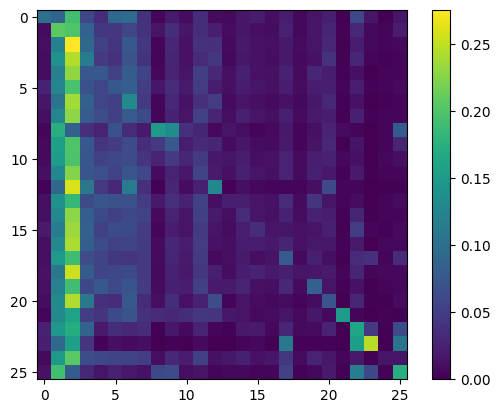

In [29]:
plt.imshow(A)
plt.colorbar()

In [24]:
index_genres

{'Western': 0,
 'Comedy': 1,
 'Drama': 2,
 'Romance': 3,
 'Thriller': 4,
 'Adventure': 5,
 'Action': 6,
 'Crime': 7,
 'Animation': 8,
 'Family': 9,
 'Fantasy': 10,
 'Fiction': 11,
 'World': 12,
 'Science': 13,
 'Mystery': 14,
 'War': 15,
 'Biography': 16,
 'Indie': 17,
 'History': 18,
 'Horror': 19,
 'Musical': 20,
 'Japanese': 21,
 'Black-and-white': 22,
 'Silent': 23,
 'Documentary': 24,
 'Short': 25}